## 기본 세팅

In [ ]:
# drive mount
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import glob
import natsort ## 숫자 정렬용 라이브러리 출처: https://mentha2.tistory.com/171 [행궁동 데이터 엔지니어]

# 확장자
extension = "*.jpg"

# 텍스트 파일이 저장될 경로
save_at = '/content/drive/MyDrive/darknet/' + 'custom.txt'

# 대상 폴더에서 지정한 확장자를 가진 파일들의 경로를 리스트화
path_list = list(glob.glob('/content/drive/MyDrive/img/' + extension))

after_path_list = natsort.natsorted(path_list) # img의 이름들이 담긴 list가 됨

# 파일들의 경로를 텍스트 파일에 추가 및 입력
for file in after_path_list:
    f = open(save_at, 'a')
    f.write(file + "\n")
f.close()

In [ ]:
# class : clear, label / 0, 1로 구분
from tqdm import tqdm 

txt_list = list(glob.glob('/content/drive/MyDrive/img/' + '*.txt'))

clear = 0
label = 0

for t in tqdm(txt_list):
  f = open(t, 'r')
  
  while True:
    line = f.readline()
    if not line: break
    
    num = line.split(' ')[0] # class 부분만 읽어오기
    
    if num == '0':
      clear += 1
    else:
      label += 1
  f.close()  

print(f'총 {len(txt_list)}개의 이미지 중 깨끗한 페트병 {clear}개, 라벨있는 페트병 {label}개')

100%|██████████| 1063/1063 [00:01<00:00, 891.84it/s] 

총 1063개의 이미지 중 깨끗한 페트병 110개, 라벨있는 페트병 969개


## darknet 과 yolo의 학습 방법

- 참고링크
  - https://github.com/tzutalin/labelImg : labelimg 사용
  - https://colab.research.google.com/drive/1_GdoqCJWXsChrOiY8sZMr_zbr_fH-0Fg?usp=sharing#scrollTo=iZULaGX7_H1u
  - https://developer-thislee.tistory.com/18?category=818795
  - 


- 필요 file

1. custom.name : class의 이름
2. custom.txt : img파일들의 경로 나열
3. yolov4.cfg : config file class와 fillter 수정해야함
4. custom.data : class의 갯수, custom.txt path, custom.name path, backup folder path

## 코랩에서 Darknet 이용해서 커스텀 데이터 학습

In [ ]:
## Cuda 버전 확인
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
# Cuda와 호환되는 버전의 cudnn 설치
!tar -xzvf /content/drive/MyDrive/cudnn-11.1-linux-x64-v8.0.5.39.tgz -C /usr/local/ > /dev/null

In [ ]:
# cudnn 버전 확인
!cat /usr/local/cuda/include/cudnn_version.h | grep CUDNN_MAJOR -A 2

#define CUDNN_MAJOR 8
#define CUDNN_MINOR 0
#define CUDNN_PATCHLEVEL 5
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#endif /* CUDNN_VERSION_H */


In [ ]:
# darknet 다운로드
%cd /content/
!git clone https://github.com/AlexeyAB/darknet.git
%ls

/content
Cloning into 'darknet'...
remote: Enumerating objects: 15363, done.
remote: Total 15363 (delta 0), reused 0 (delta 0), pack-reused 15363
Receiving objects: 100% (15363/15363), 14.00 MiB | 14.97 MiB/s, done.
Resolving deltas: 100% (10331/10331), done.
darknet/  drive/  sample_data/


In [ ]:
# Makrfile 변경
%cd /content/darknet/
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

/content/darknet


In [ ]:
# darknet 컴파일
!make > /dev/null

In [ ]:
# 컴파일한 darknet 드라이브로 복사 https://hanryang1125.tistory.com/17
%cp -r ./darknet /content/drive/MyDrive/darknet

### 학습이 끝난뒤 여기부터 시작

In [ ]:
# darknet 권한 변경 및 실행 테스트
# !wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137
%cd /content/drive/MyDrive/darknet
!chmod +x ./darknet
!./darknet detector

/content/drive/MyDrive/darknet
 CUDA-version: 11010 (11020), cuDNN: 8.0.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
usage: ./darknet detector [train/test/valid/demo/map] [data] [cfg] [weights (optional)]


In [ ]:
# 현재 런타임이 GPU를 사용하고있는지 확인(cuda를 사용하고있는지)
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# Colab에서 제공해주는 함수
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

In [ ]:
# 접근 권한 부여
!chmod +x custom.data
!chmod +x yolov4.cfg
!chmod +x yolov4.weights
!chmod +x pose/custom.txt
!chmod -R 777 pose

In [ ]:
%ls

chart_1117.png         chart_yolov4.png  data/            yolov4.cfg*
chart.png              custom.data*      pose/            yolov4.conv.137
chart_yolov4_1117.png  darknet*          predictions.jpg  yolov4.weights*


In [ ]:
# .\darknet.exe detector train pose/custom.data pose/yolov4-custom.cfg yolov4.conv.137

In [ ]:
# darknet을 이용하여 학습 
!./darknet detector train custom.data yolov4.cfg yolov4.conv.137 -dont_show

Loaded: 5.077297 seconds - performance bottleneck on CPU or Disk HDD/SSD
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 139 Avg (IOU: 0.749518), count: 11, class_loss = 1.441656, iou_loss = 6.361152, total_loss = 7.802808 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 150 Avg (IOU: 0.718916), count: 64, class_loss = 4.927943, iou_loss = 6.041370, total_loss = 10.969314 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 161 Avg (IOU: 0.694931), count: 41, class_loss = 3.027213, iou_loss = 0.685022, total_loss = 3.712235 
 total_bbox = 2100456, rewritten_bbox = 0.000000 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 139 Avg (IOU: 0.668197), count: 6, class_loss = 0.875877, iou_loss = 1.809669, total_loss = 2.685546 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 150 Avg (IOU: 0.734158), count: 53, class_loss = 3.444425, iou_loss = 4.896459, total_loss = 8.340884 
v3 (iou loss, Normalizer:

In [ ]:
# 만들어진 weights로 테스트 https://pgmrlsh.tistory.com/6
# -ext_output 붙이면 rect 테두리 값을 알 수 있음
!./darknet detector test custom.data yolov4.cfg pose/backup/yolov4_4000.weights data/2.jpg -dont_show -ext_output > /content/a.txt

 CUDA-version: 11010 (11020), cuDNN: 8.0.5, CUDNN_HALF=1, GPU count: 1  
 OpenCV version: 3.2.0
Cannot load image data/labels/32_0.png
Cannot load image data/labels/33_0.png
Cannot load image data/labels/34_0.png
Cannot load image data/labels/35_0.png
Cannot load image data/labels/36_0.png
Cannot load image data/labels/37_0.png
Cannot load image data/labels/38_0.png
Cannot load image data/labels/39_0.png
Cannot load image data/labels/40_0.png
Cannot load image data/labels/41_0.png
Cannot load image data/labels/42_0.png
Cannot load image data/labels/43_0.png
Cannot load image data/labels/44_0.png
Cannot load image data/labels/45_0.png
Cannot load image data/labels/46_0.png
Cannot load image data/labels/47_0.png
Cannot load image data/labels/48_0.png
Cannot load image data/labels/49_0.png
Cannot load image data/labels/50_0.png
Cannot load image data/labels/51_0.png
Cannot load image data/labels/52_0.png
Cannot load image data/labels/53_0.png
Cannot load image data/labels/54_0.png
Cannot 

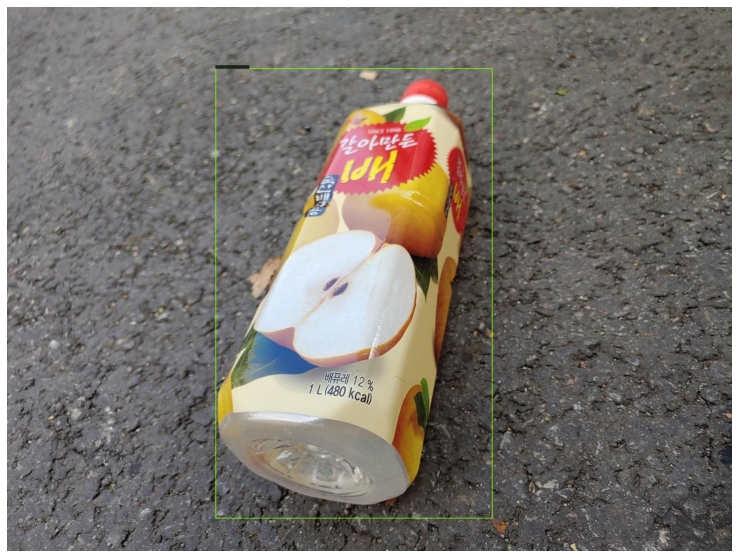

In [ ]:
# show image using our helper function
imShow('predictions.jpg')

In [ ]:
!cat /content/a.txt

## 함수 테스트

In [ ]:
import cv2
import matplotlib.pyplot as plt
from utils import *
import darknet

In [ ]:
from darknetpy.detector import Detector

detector = Detector('<absolute-path-to>/darknet',
                    '<absolute-path-to>/darknet/cfg/coco.data',
                    '<absolute-path-to>/darknet/cfg/yolov3.cfg',
                    '<absolute-path-to>/darknet/yolov3.weights')

results = detector.detect('<absolute-path-to>/darknet/data/dog.jpg')

print(results)

In [ ]:
import cv2
import matplotlib.pyplot as plt
from utils import *
from darknet import Darknet
net = Darknet("cfg/tiny-yolo.cfg")
net.load_weights("tiny-yolo.weights")

In [ ]:
# Stupid python path shit.
# Instead just add darknet.py to somewhere in your python path
# OK actually that might not be a great idea, idk, work in progress
# Use at your own risk. or don't, i don't care

net = dn.load_net(b"./yolov4.cfg", b".pose/backup/yolov4_4000.weights", 0)
meta = darknet.load_meta("./custom.data".encode('utf-8'))

import sys, os
sys.path.append(os.path.join(os.getcwd(),'python/'))

import darknet as dn
import pdb

dn.set_gpu(0)
net = dn.load_net("cfg/yolo-thor.cfg", "/home/pjreddie/backup/yolo-thor_final.weights", 0)
meta = dn.load_meta("cfg/thor.data")
r = dn.detect(net, meta, "data/bedroom.jpg")
print r

# And then down here you could detect a lot more images like:
r = dn.detect(net, meta, "data/eagle.jpg")
print r
r = dn.detect(net, meta, "data/giraffe.jpg")
print r
r = dn.detect(net, meta, "data/horses.jpg")
print r
r = dn.detect(net, meta, "data/person.jpg")
print r